# 1. Importing relevant packages


In [1]:
### relevant models
import torch  
import torch.nn as nn  
import torch.nn.functional as F 
import torchvision.models as models  
import torchvision
from torchvision.models.segmentation import fcn_resnet50 
import torch.nn.utils as utils
import torch.optim as optim
import torchvision.utils as vision_utils  
from tensorboardX import SummaryWriter

### data loading 
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import torch

### img processing,csv, etc.
import time  
import math
import argparse as arg 
import datetime
import os
import numpy as np  
import pandas as pd
from io import BytesIO
import random
from itertools import permutations
import matplotlib.pyplot as plt
import gc
import matplotlib
import matplotlib.cm as cm
from PIL import Image
import cv2     
from glob import glob

_check_pil = lambda x: isinstance(x, Image.Image)
_check_np_img = lambda x: isinstance(x, np.ndarray)


# 2.Define Model DenseDepth


In [2]:
# encoder
class Encoder(nn.Module):
    def __init__(self, encoder_pretrained=True):
        super(Encoder, self).__init__() 
        self.densenet = models.densenet161(pretrained=encoder_pretrained)
    
    def forward(self, x):
        feature_maps = [x]
        for key, value in self.densenet.features._modules.items():
            feature_maps.append(value(feature_maps[-1]))
        return feature_maps

#up sampling
class Upsample(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(Upsample, self).__init__() 
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.convA = nn.Conv2d(input_channels, output_channels, 3, 1, 1)
        self.leakyrelu = nn.LeakyReLU(0.2)
        self.convB = nn.Conv2d(output_channels, output_channels, 3, 1, 1)

    def forward(self, x, concat_with):
        concat_h_dim = concat_with.shape[2]
        concat_w_dim = concat_with.shape[3]
        upsampled_x = F.interpolate(x, size=[concat_h_dim, concat_w_dim], mode="bilinear", align_corners=True)
        upsampled_x = torch.cat([upsampled_x, concat_with], dim=1)
    
        upsampled_x = self.convA(upsampled_x)
        upsampled_x = self.leakyrelu(upsampled_x)
        upsampled_x = self.convB(upsampled_x)
        upsampled_x = self.leakyrelu(upsampled_x)

        return upsampled_x

# decoder
class Decoder(nn.Module):
    def __init__(self, num_features=2208, decoder_width=0.5, scales=[1, 2, 4, 8]):
        super(Decoder, self).__init__()
        features = int(num_features * decoder_width)
        
        self.conv2 = nn.Conv2d(num_features, features, 1, 1, 1)
        
        self.upsample1 = Upsample(features//scales[0] + 384, features//(scales[0] * 2))
        self.upsample2 = Upsample(features//scales[1] + 192, features//(scales[1] * 2))
        self.upsample3 = Upsample(features//scales[2] + 96, features//(scales[2] * 2))
        self.upsample4 = Upsample(features//scales[3] + 96, features//(scales[3] * 2))

        self.conv3 = nn.Conv2d(features//(scales[3] * 2), 1, 3, 1, 1)

    def forward(self, features):
        x_block0= features[3]
        x_block1 = features[4]
        x_block2 = features[6]
        x_block3 = features[8]
        x_block4 = features[11]

        x0 = self.conv2(x_block4)
        x1 = self.upsample1(x0, x_block3)
        x2 = self.upsample2(x1, x_block2)
        x3 = self.upsample3(x2, x_block1)
        x4 = self.upsample4(x3, x_block0)

        return self.conv3(x4)

# densedepth
class DenseDepth(nn.Module):
    def __init__(self, encoder_pretrained=True):
        super(DenseDepth, self).__init__()
        self.encoder = Encoder(encoder_pretrained=encoder_pretrained)
        self.decoder = Decoder()
    
    def forward(self, x):
        encoder_out = self.encoder(x)
        decoder_out = self.decoder(encoder_out)
        return decoder_out


In [3]:
# random horizontal flip
class RandomHorizontalFlip(object):
    def __call__(self, sample):
        img, depth = sample["image"], sample["depth"]
        if random.random() < 0.5:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
            depth = depth.transpose(Image.FLIP_LEFT_RIGHT)
        return {
            "image": img, 
            "depth": depth
        }

# random channel swap
class RandomChannelSwap(object):
    def __init__(self, probability):
        self.probability = probability
        self.indices = list(permutations(range(3), 3))
        
    def __call__(self, sample):
        image, depth = sample["image"], sample["depth"]
        if random.random() < self.probability:
            image = np.asarray(image)
            channels_to_swap = [0, 1, 2]
            np.random.shuffle(channels_to_swap)
            image = image[:, :, channels_to_swap]
            image = Image.fromarray(image.astype('uint8'), 'RGB')
        return {"image": image, "depth": depth}

# load zip to memory
def loadZipToMem(zip_file):
    # Load zip file into memory
    print('Loading dataset zip file...', end='')
    from zipfile import ZipFile
    input_zip = ZipFile(zip_file)
    data = {name: input_zip.read(name) for name in input_zip.namelist()}
    nyu2_train = list((row.split(',') for row in (data['data/nyu2_train.csv']).decode("utf-8").split('\n') if len(row) > 0))

    from sklearn.utils import shuffle
    nyu2_train = shuffle(nyu2_train, random_state=0)
    print('Loaded ({0}).'.format(len(nyu2_train)))
    return data, nyu2_train

# NYU dataset
class NYUDataset(Dataset):
    def __init__(self, data, nyu2_train, transform=None):
        self.data, self.nyu_dataset = data, nyu2_train
        self.transform = transform

    def __getitem__(self, idx):
        sample = self.nyu_dataset[idx]
        image = Image.open( BytesIO(self.data[sample[0]]) )
        depth = Image.open( BytesIO(self.data[sample[1]]) )
        sample = {'image': image, 'depth': depth}
        if self.transform: sample = self.transform(sample)
        return sample

    def __len__(self):
        return len(self.nyu_dataset)
    
# load torch to tensor
class ToTensor(object):
    def __init__(self,is_test=False):
        self.is_test = is_test

    def __call__(self, sample):
        image, depth = sample['image'], sample['depth']
        image = self.to_tensor(image)
        depth = depth.resize((320, 240))
        if self.is_test:
            depth = self.to_tensor(depth).float() / 1000
        else:            
            depth = self.to_tensor(depth).float() * 1000
        # put in expected range
        depth = torch.clamp(depth, 10, 1000)
        return {'image': image, 'depth': depth}

    def to_tensor(self, pic):
        if not(_check_pil(pic) or _check_np_img(pic)):
            raise TypeError(
                'pic should be PIL Image or ndarray. Got {}'.format(type(pic)))
        if isinstance(pic, np.ndarray):
            img = torch.from_numpy(pic.transpose((2, 0, 1)))
            return img.float().div(255)

        # handle PIL Image
        if pic.mode == 'I':
            img = torch.from_numpy(np.array(pic, np.int32, copy=False))
        elif pic.mode == 'I;16':
            img = torch.from_numpy(np.array(pic, np.int16, copy=False))
        else:
            img = torch.ByteTensor(
                torch.ByteStorage.from_buffer(pic.tobytes()))

        if pic.mode == 'YCbCr':
            nchannel = 3
        elif pic.mode == 'I;16':
            nchannel = 1
        else:
            nchannel = len(pic.mode)
        img = img.view(pic.size[1], pic.size[0], nchannel)

        img = img.transpose(0, 1).transpose(0, 2).contiguous()
        if isinstance(img, torch.ByteTensor):
            return img.float().div(255)
        else:
            return img

#get no transform
def getNoTransform(is_test=False):
    return transforms.Compose([
        ToTensor(is_test=is_test)
    ])

# get default train transform
def getDefaultTrainTransform():
    return transforms.Compose([
        RandomHorizontalFlip(),
        RandomChannelSwap(0.5),
        ToTensor()
    ])

#get train dataset
def get_train_dataset(path):
    data, nyu2_train = loadZipToMem(path)
    transformed_training = NYUDataset(data, nyu2_train, transform=getDefaultTrainTransform())
    return transformed_training
    
# get test dataset
def get_test_dataset(path):
    data, nyu2_train = loadZipToMem(path)
    transformed_testing = NYUDataset(data, nyu2_train, transform=getNoTransform())
    return transformed_testing

# get data loader
def get_data_loaders(path, batch_size):
    data, nyu2_train = loadZipToMem(path)
    transformed_training = NYUDataset(data, nyu2_train, transform=getDefaultTrainTransform())
    transformed_testing = NYUDataset(data, nyu2_train, transform=getNoTransform())

    return DataLoader(transformed_training, batch_size, shuffle=True), DataLoader(transformed_testing, batch_size, shuffle=False)
  
# get trainloader
def get_trainloader(path, batch_size):
    data, nyu2_train = loadZipToMem(path)
    transformed_training = NYUDataset(data, nyu2_train, transform=getDefaultTrainTransform())
    return DataLoader(transformed_training, batch_size, shuffle=True)
  
# get testloader
def get_testloader(path, batch_size=1):
    data, nyu2_train = loadZipToMem(path)
    transformed_testing = NYUDataset(data, nyu2_train, transform=getNoTransform())
    return DataLoader(transformed_testing, batch_size, shuffle=False)


In [4]:
###### LOSS ######
# gaussian
def gaussian(window_size, sigma):
    gauss =  torch.Tensor([math.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

# create window
def create_window(window_size, channel=1):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)

    window = torch.Tensor(_2D_window.expand(channel, 1, window_size, window_size).contiguous())

    return window

# ssim
def ssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):
    L = val_range # L is the dynamic range of the pixel values (255 for 8-bit grayscale images),

    pad = window_size // 2
    
    try:
        _, channels, height, width = img1.size()
    except:
        channels, height, width = img1.size()

    # if window is not provided, init one
    if window is None: 
        real_size = min(window_size, height, width) # window should be at least 11x11 
        window = create_window(real_size, channel=channels).to(img1.device)
    
    # calculating the mu parameter (locally) for both images using a gaussian filter 
    # calculates the luminosity params
    mu1 = F.conv2d(img1, window, padding=pad, groups=channels)
    mu2 = F.conv2d(img2, window, padding=pad, groups=channels)
    
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2 
    mu12 = mu1 * mu2

    # now we calculate the sigma square parameter
    # Sigma deals with the contrast component 
    sigma1_sq = F.conv2d(img1 * img1, window, padding=pad, groups=channels) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=pad, groups=channels) - mu2_sq
    sigma12 =  F.conv2d(img1 * img2, window, padding=pad, groups=channels) - mu12

    # Some constants for stability 
    C1 = (0.01 ) ** 2  
    C2 = (0.03 ) ** 2 

    contrast_metric = (2.0 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)
    contrast_metric = torch.mean(contrast_metric)

    numerator1 = 2 * mu12 + C1  
    numerator2 = 2 * sigma12 + C2
    denominator1 = mu1_sq + mu2_sq + C1 
    denominator2 = sigma1_sq + sigma2_sq + C2

    ssim_score = (numerator1 * numerator2) / (denominator1 * denominator2)

    if size_average:
        ret = ssim_score.mean() 
    else: 
        ret = ssim_score.mean(1).mean(1).mean(1)
    
    if full:
        return ret, contrast_metric
    
    return ret

# calculate gradients
def image_gradients(img, device):
    if len(img.shape) != 4:
        raise ValueError("Shape mismatch. Needs to be 4 dim tensor")
    
    img_shape = img.shape
    batch_size, channels, height, width = img.shape
  
    dy = img[:, :, 1:, :] - img[:, :, :-1, :]
    dx = img[:, :, :, 1:] - img[:, :, :, :-1]

    shape = np.stack([batch_size, channels, 1, width])
    dy = torch.cat([dy, torch.zeros([batch_size, channels, 1, width], device=device, dtype=img.dtype)], dim=2)
    dy = dy.view(img_shape)

    shape = np.stack([batch_size, channels, height, 1])
    dx = torch.cat([dx, torch.zeros([batch_size, channels, height, 1], device=device, dtype=img.dtype)], dim=3)
    dx = dx.view(img_shape)

    return dy, dx

# calculate depth loss
def depth_loss(y_true, y_pred, theta=0.1, device="cuda", maxDepth=1000.0/10.0):
    # gradients
    dy_true, dx_true = image_gradients(y_true, device)
    dy_pred, dx_pred = image_gradients(y_pred, device)
    l_edges = torch.mean(torch.abs(dy_pred-dy_true) + torch.abs(dx_pred-dx_true), dim=1) 

    return l_edges


##### utils ######
# depth norm
def DepthNorm(depth, max_depth=1000.0):
    return max_depth / depth

# torch avg meter
class AverageMeter(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0 
        self.avg = 0 
        self.sum = 0
        self.count = 0 

    def update(self, val, n=1):
        self.val = val 
        self.sum += val * n 
        self.count += n 
        self.avg = self.sum / self.count  

# colorize the image
def colorize(value, vmin=10, vmax=1000, cmap="magma_r"):
    value = value.cpu().numpy()[0, :, :]
    # normalize 
    vmin = value.min() if vmin is None else vmin 
    vmax = value.max() if vmax is None else vmax   
    if vmin != vmax:
        value = (value - vmin) / (vmax - vmin)
    else:
        value = value * 0  
    
    cmapper =  cm.get_cmap(cmap)
    value = cmapper(value, bytes=True) 

    img = value[:,:,:3]

    return img.transpose((2, 0, 1))

# load from checkpoint
def load_from_checkpoint(ckpt, model, optimizer, epochs, loss_meter=None):
    checkpoint = torch.load(ckpt)
    ckpt_epoch = epochs - (checkpoint["epoch"]+1)
    if ckpt_epoch <= 0:
        raise ValueError("Epochs provided: {}, epochs completed in ckpt: {}".format(
    epochs, checkpoint["epoch"]+1))

    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optim_state_dict"])
    
    return model, optimizer, ckpt_epoch

# load local img
def load_images(image_files):
    loaded_images = []
    for file in image_files:
        x = np.clip(np.asarray(Image.open( file ).resize((640, 480)), dtype=float) / 255, 0, 1).transpose(2, 0, 1)
        loaded_images.append(x)
    return np.stack(loaded_images, axis=0)
    
# init and load model
def init_or_load_model(pretrained, epochs, lr, ckpt=None, device=torch.device("cuda:0"), loss_meter=None):
    if ckpt is not None: 
        checkpoint = torch.load(ckpt)
    
    model = DenseDepth(pretrained)
    if ckpt is not None:
        model.load_state_dict(checkpoint["model_state_dict"])

    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    if ckpt is not None:
        optimizer.load_state_dict(checkpoint["optim_state_dict"])
    
    start_epoch = 0
    if ckpt is not None:
        start_epoch = checkpoint["epoch"]+1
        if start_epoch <= 0:
            raise ValueError("Epochs provided: {}, epochs completed in ckpt: {}".format(
                        epochs, checkpoint["epoch"]+1))
    
    return model, optimizer, start_epoch

# tensorboard record results for training
def LogProgress(model, writer, test_loader, epoch, device):
    
    """ To record intermediate results of training""" 

    model.eval() 
    sequential = test_loader
    sample_batched = next(iter(sequential))
    
    image = torch.Tensor(sample_batched["image"]).to(device)
    depth = torch.Tensor(sample_batched["depth"]).to(device)
    
    if epoch == 0:
        writer.add_image("Train.1.Image", vision_utils.make_grid(image.data, nrow=6, normalize=True), epoch)
    if epoch == 0:
        writer.add_image("Train.2.Image", colorize(vision_utils.make_grid(depth.data, nrow=6, normalize=False)), epoch)
    
    output = DepthNorm(model(image))

    writer.add_image("Train.3.Ours", colorize(vision_utils.make_grid(output.data, nrow=6, normalize=False)), epoch)
    writer.add_image("Train.4.Diff", colorize(vision_utils.make_grid(torch.abs(output-depth).data, nrow=6, normalize=False)), epoch)
    
    del image
    del depth
    del output



###### train ######
def train(epochs, 
        trainloader,
        testloader,
        lr=0.0001, 
        save="checkpoints/", 
        theta=0.1, 
        device="cuda", 
        pretrained=True,
        checkpoint=None):

    num_trainloader = len(trainloader)
    num_testloader = len(testloader)

    # train model
    model_prefix = "monocular_"
    device = torch.device("cuda:0" if device == "cuda" else "cpu")
    theta = theta
    save_count = 0
    epoch_loss = []
    batch_loss = []
    sum_loss = 0

    if checkpoint:
        print("Loading from checkpoint ...")
        
        model, optimizer, start_epoch = init_or_load_model(pretrained=pretrained,
                                                            epochs=epochs,
                                                            lr=lr,
                                                            ckpt=checkpoint, 
                                                            device=device                                            
                                                            )
        print("Resuming from: epoch #{}".format(start_epoch))

    else:
        print("Initializing fresh model ...")

        model, optimizer, start_epoch = init_or_load_model(pretrained=pretrained,
                                                            epochs=epochs,
                                                            lr=lr,
                                                            ckpt=None, 
                                                            device=device                                            
                                                            )

    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    if pretrained:
        log_dir = 'runs/pretrained'
    else:
        log_dir = 'runs/not_pretrained'
    # log record
    writer = SummaryWriter(log_dir,comment="{}-training".format(model_prefix))
    
    # loss function
    l1_criterion = nn.L1Loss() 
 
    print("Starting training ... ")
     
    for epoch in range(start_epoch, epochs):
        
        model.train()
        model = model.to(device)

        batch_time = AverageMeter() 
        loss_meter = AverageMeter() 

        epoch_start = time.time()
        end = time.time()

        for idx, batch in enumerate(trainloader):

            optimizer.zero_grad() 

            image_x = torch.Tensor(batch["image"]).to(device=device)
            depth_y = torch.Tensor(batch["depth"]).to(device=device)

            normalized_depth_y = DepthNorm(depth_y)

            preds = model(image_x) 

            # calculate loss
            l1_loss = l1_criterion(normalized_depth_y, preds) 
            
            ssim_loss = torch.clamp(
                (1-ssim(preds, normalized_depth_y, 1000.0/10.0))*0.5, 
                min=0, 
                max=1
            )

            gradient_loss = depth_loss(normalized_depth_y, preds, device=device)
            
            # loss = ssim+gradient+l1
            net_loss = (1.0 * ssim_loss) + (1.0 * torch.mean(gradient_loss)) + (theta * torch.mean(l1_loss))
           
            loss_meter.update(net_loss.data.item(), image_x.size(0))
            net_loss.backward()
            optimizer.step()

            # run time record
            batch_time.update(time.time() - end)
            end = time.time()
            eta = str(datetime.timedelta(seconds=int(batch_time.val*(num_trainloader-idx))))

            # update log 
            num_iters = epoch * num_trainloader + idx  
            if idx % 5 == 0 :
                print(
                    "Epoch: #{0} Batch: {1}/{2}\t"
                    "Time (current/total) {batch_time.val:.3f}/{batch_time.sum:.3f}\t"
                    "eta {eta}\t"
                    "LOSS (current/average) {loss.val:.4f}/{loss.avg:.4f}\t"
                    .format(epoch, idx, num_trainloader, batch_time=batch_time, eta=eta, loss=loss_meter)
                )

                writer.add_scalar("Train/Loss", loss_meter.val, num_iters)
            if idx%1000 == 0:
                if pretrained:
                    ckpt_path = save+"ckpt_{}_pretrained.pth".format(epoch)
                else:
                    ckpt_path = save+"ckpt_{}_not_pretrained.pth".format(epoch)
                torch.save({
                    "epoch": epoch, 
                    "model_state_dict": model.state_dict(),
                    "optim_state_dict":  optimizer.state_dict(),
                    "loss": loss_meter.avg
                }, ckpt_path) 

                LogProgress(model, writer, testloader, num_iters, device)
            del image_x
            del depth_y
            del preds          
        
        print(
            "----------------------------------\n"
            "Epoch: #{0}, Avg. Net Loss: {avg_loss:.4f}\n"
            "----------------------------------"
            .format(
                epoch, avg_loss=loss_meter.avg
            )
        )

    
    

def test(checkpoint, 
        device="cuda", 
        data="examples/"):

    if len(checkpoint) and not os.path.isfile(checkpoint):
        raise FileNotFoundError("{} no such file".format(checkpoint))    

    device = torch.device("cuda" if device == "cuda" else "cpu")
    print("Using device: {}".format(device))

    # init and load model
    ckpt = torch.load(checkpoint)
    model = DenseDepth(encoder_pretrained=False)
    model.load_state_dict(ckpt["model_state_dict"])
    model = model.to(device)
    print("model load from checkpoint complete ...")

    # get test png img 
    img_list = glob(data+"*.png")
    
    # test
    model.eval()

    print("Begin Test Loop ...")

    fig, axs = plt.subplots(3, 2)
    for idx, img_name in enumerate(img_list):

        img = load_images([img_name])
        if idx < 3:     
            axs[idx, 0].imshow(img[0].transpose(1, 2, 0))
            axs[idx, 0].axis('off')
        img = torch.Tensor(img).float().to(device)   

        with torch.no_grad():
            preds = DepthNorm(model(img).squeeze(0))            

        output = colorize(preds.data)
        output = output.transpose((1, 2, 0))
        if idx < 3:     
            axs[idx, 1].imshow(output, cmap='gray')
            axs[idx, 1].axis('off')
        output=output[:,:,::-1]
        cv2.imwrite(img_name.split(".")[0].replace(data,data+'output/')+"_result.png", output)

        print("Processing {} done.".format(img_name))
    plt.show()



# 4. Load and Observe Data


Loading dataset zip file...Loaded (50688).


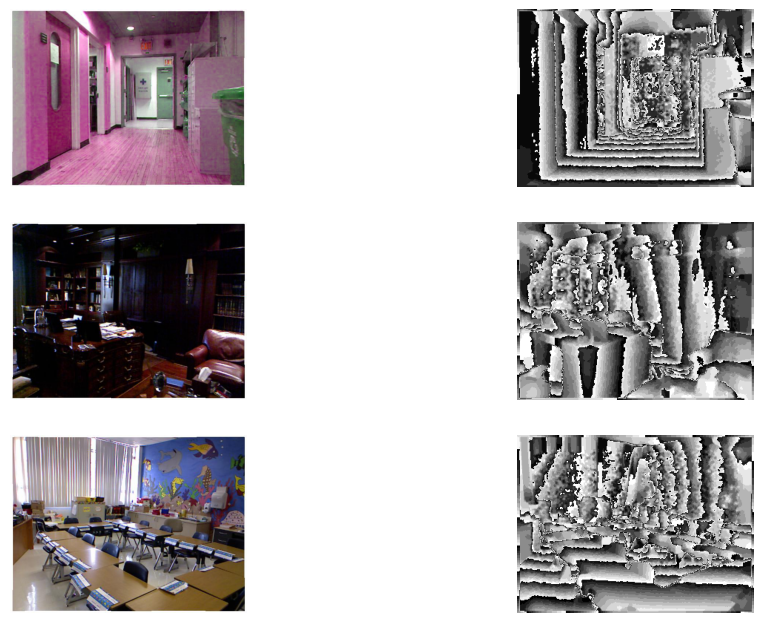

In [6]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 

tensorToImage = torchvision.transforms.ToPILImage()
trainloader, testloader = get_data_loaders("data/nyu_data.zip", 
                                           batch_size=1)
dataiter = iter(trainloader)
fig, axs = plt.subplots(3, 2)
for i in range(3):
    data = next(dataiter)
    axs[i, 0].imshow(tensorToImage(data['image'][0]))
    axs[i, 1].imshow(tensorToImage(data['depth'][0]), cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')

# 5. Training Model 10epoch around 20hours

In [6]:
train(10, trainloader, testloader, lr=0.0001, pretrained=True)

# 6.Test Model, Load Pre-Trained Model

Using device: cuda
model load from checkpoint complete ...
Begin Test Loop ...
Processing examples\119_image.png done.
Processing examples\11_image.png done.
Processing examples\140_image.png done.
Processing examples\1_image.png done.
Processing examples\267_image.png done.
Processing examples\308_image.png done.
Processing examples\312_image.png done.
Processing examples\358_image.png done.
Processing examples\377_image.png done.
Processing examples\470_image.png done.
Processing examples\499_image.png done.
Processing examples\626_image.png done.
Processing examples\what-is-impeding-traffic-in-michigan.png done.


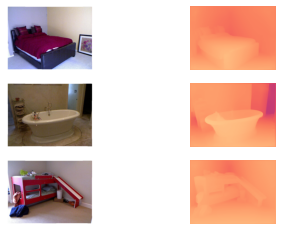

In [12]:
test('checkpoints/ckpt_pretrained.pth')